<a href="https://colab.research.google.com/github/ahmedalyfayyad/coloncare_web/blob/main/Colon_Cancer_Detetion_EfficientNetB3_WCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from pathlib import Path
import pandas as pd

# المسار للمجلد الذي يحتوي على الصور
base_path = Path("/kaggle/input/coloncancerct-2025-abdominal-ct-scans/ColonCancerCT-2025 A Dataset of Abdominal CT Scans/Split_Data/Split_Data/train")

# جمع كل الصور الموجودة في المجلدات
filepaths = list(base_path.rglob("*.png"))

# بناء DataFrame بالمسارات والفئات
df = pd.DataFrame({
    'filepaths': [str(p) for p in filepaths],
    'labels': [p.parent.name for p in filepaths]
})

# Encode labels
df['encoded_labels'] = df['labels'].astype('category').cat.codes

# عرض بعض البيانات للتحقق
print(df.head())
print(df['labels'].value_counts())


                                           filepaths  labels  encoded_labels
0  /kaggle/input/coloncancerct-2025-abdominal-ct-...  cancer               1
1  /kaggle/input/coloncancerct-2025-abdominal-ct-...  cancer               1
2  /kaggle/input/coloncancerct-2025-abdominal-ct-...  cancer               1
3  /kaggle/input/coloncancerct-2025-abdominal-ct-...  cancer               1
4  /kaggle/input/coloncancerct-2025-abdominal-ct-...  cancer               1
labels
Non_Cancer    4761
cancer        3176
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# تقسيم البيانات إلى Train و Test و Validation
train_df, temp_df = train_test_split(df, stratify=df['encoded_labels'], test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['encoded_labels'], test_size=0.5, random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 4762 | Val: 1587 | Test: 1588


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


2025-06-11 23:04:54.895011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749683095.449066      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749683095.581156      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 4762 validated image filenames belonging to 2 classes.
Found 1587 validated image filenames belonging to 2 classes.
Found 1588 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# تحميل EfficientNetB3 بدون الطبقات العليا
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# بناء الموديل
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # 2 classes (Cancer & Non_Cancer)

# إنشاء النموذج باستخدام الطبقات المدخلة والمخرجة
model = Model(inputs=base_model.input, outputs=output)

# تجميع الموديل
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 224, 224, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,980,529 (41.89 MB)

 Trainable params: 10,893,226 (41.55 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [ ]:
# EarlyStopping and ReduceLROnPlateau callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5)

# تدريب الموديل
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

# تقييم الموديل على الـ Test set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")

# حفظ الموديل
model.save("colon_cancer_classifier.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749683455.035550      96 service.cc:148] XLA service 0x792054003650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749683455.037562      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749683455.037587      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749683463.116975      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749683479.860641      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749683480.008095      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749683480.534283      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 46/149 ━━━━━━━━━━━━━━━━━━━━ 41s 400ms/step - accuracy: 0.6520 - loss: 0.6147

E0000 00:00:1749683549.966494      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749683550.110971      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749683550.635146      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749683550.782068      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


149/149 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.7607 - loss: 0.4611 - val_accuracy: 0.5923 - val_loss: 0.6676 - learning_rate: 1.0000e-04
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 359ms/step - accuracy: 0.9704 - loss: 0.0757 - val_accuracy: 0.6856 - val_loss: 0.6496 - learning_rate: 1.0000e-04
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 51s 344ms/step - accuracy: 0.9883 - loss: 0.0374 - val_accuracy: 0.4953 - val_loss: 0.7988 - learning_rate: 1.0000e-04
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 52s 351ms/step - accuracy: 0.9919 - loss: 0.0230 - val_accuracy: 0.6679 - val_loss: 0.6083 - learning_rate: 1.0000e-04
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 52s 348ms/step - accuracy: 0.9944 - loss: 0.0167 - val_accuracy: 0.7209 - val_loss: 0.6089 - learning_rate: 1.0000e-04
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 52s 347ms/step - accuracy: 0.9918 - loss: 0.0183 - val_accuracy: 0.4102 - val_loss: 1.1937 - learning_rate: 1.0000e-04
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 52s 351ms/step - ac

In [ ]:
# تقييم الموديل على الـ Test set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.9972 - loss: 0.0146
Test Accuracy: 0.9969 | Test Loss: 0.0184


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step


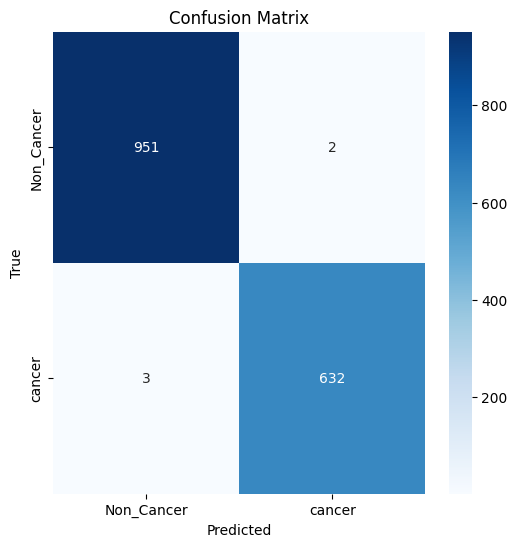

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate confusion matrix
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("colon_cancer_classifier.h5")
